In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

### Online and Offline Training data

In [2]:
df_on = pd.read_csv('DataSets/ccf_online_stage1_train.csv')
df_off = pd.read_csv('DataSets/ccf_offline_stage1_train.csv')

In [3]:
print("Online Training Data Sample\nShape:"+str(df_on.shape))
df_on.head()

Online Training Data Sample
Shape:(11429826, 7)


,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date
0,13740231,18907,2,100017492,500:50,20160513.0,NaN
1,13740231,34805,1,NaN,NaN,NaN,20160321.0
2,14336199,18907,0,NaN,NaN,NaN,20160618.0
3,14336199,18907,0,NaN,NaN,NaN,20160618.0
4,14336199,18907,0,NaN,NaN,NaN,20160618.0


In [4]:
print("Offline Training Data Sample\nShape:"+str(df_off.shape))
df_off.head()

Offline Training Data Sample
Shape:(1754884, 7)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN


### TEST DATA (OFFLINE)

In [5]:
df_test = pd.read_csv('DataSets/ccf_offline_stage1_test_revised.csv')
print("Testing Data(Offline) Sample\nShape:"+str(df_test.shape))
df_test.head()

Testing Data(Offline) Sample
Shape:(113640, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,4129537,450,9983,30:5,1.0,20160712
1,6949378,1300,3429,30:5,NaN,20160706
2,2166529,7113,6928,200:20,5.0,20160727
3,2166529,7113,1808,100:10,5.0,20160727
4,6172162,7605,6500,30:1,2.0,20160708


#### Converting Date to DateTime format

In [6]:
#Online Training Data
df_on['Date'] = pd.to_datetime(df_on["Date"],format='%Y%m%d')
df_on['Date_received'] = pd.to_datetime(df_on["Date_received"],format='%Y%m%d')

#Offline Training Data
df_off['Date'] = pd.to_datetime(df_off["Date"],format='%Y%m%d')
df_off['Date_received'] = pd.to_datetime(df_off["Date_received"],format='%Y%m%d')

### Removing Duplicates from Online and Offline Training Data

In [7]:
#Removing duplicates and giving frequency counts(Count) to each row

#Online
x = 'g8h.|$hTdo+jC9^@'    
df_on_unique = (df_on.fillna(x).groupby(['User_id', 'Merchant_id', 'Action', 'Coupon_id', 'Discount_rate',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_on_unique["Date_received"]=pd.to_datetime(df_on_unique["Date_received"])
df_on_unique["Date"]=pd.to_datetime(df_on_unique["Date"])

print("Online Training Data Shape:"+str(df_on_unique.shape))

Online Training Data Shape:(5822543, 8)


In [8]:
#Offline
x = 'g8h.|$hTdo+jC9^@'   #garbage value for nan values 
df_off_unique = (df_off.fillna(x).groupby(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date']).size().reset_index()
               .rename(columns={0 : 'Count'}).replace(x,np.NaN))
df_off_unique["Date_received"]=pd.to_datetime(df_off_unique["Date_received"])
df_off_unique["Date"]=pd.to_datetime(df_off_unique["Date"])

print("Offline Training Data Shape:"+str(df_off_unique.shape))

Offline Training Data Shape:(1716991, 8)


#### Filling Nan for Distance (OFFLINE)

In [9]:
df_off_unique['Distance'].fillna(df_off_unique['Distance'].mean(), inplace=True)
df_off_unique['Distance'] = df_off_unique.Distance.astype(int)

### Converting Discount Ratio to Rate

In [10]:
#Funtion to convert discount ratio to discount rate
def convert_discount(discount):
    values = []
    for i in discount:
        if ':' in i:
            i = i.split(':')
            rate = round((int(i[0]) - int(i[1]))/int(i[0]),3)
            values.append([int(i[0]),int(i[1]),rate])
        elif '.' in i:
            i = float(i)
            x = 100*i
            values.append([100,int(100-x),i])
            
    discounts = dict(zip(discount,values))      
    return discounts
    

# convert_discount(list(df_of['Discount_rate']))

In [11]:
#ONLINE DATA
df_on_coupon = df_on_unique[(df_on_unique['Coupon_id'].isna()==False) & (df_on_unique['Coupon_id']!='fixed')]
discounts_online = list(df_on_coupon['Discount_rate'].unique())
df_on_coupon.loc[:,('Discount')] = df_on_coupon.loc[:,('Discount_rate')] 
df_on_coupon.loc[:,('Discount_rate')] = df_on_coupon.loc[:,('Discount')].map(convert_discount(discounts_online))
df_on_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_on_coupon.Discount_rate.values.tolist(), index= df_on_coupon.index)
df_on_coupon.head()

,User_id,Merchant_id,Action,Coupon_id,Discount_rate,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,25104,2,100145044,"[100, 10, 0.9]",2016-03-31,NaT,1,100:10,100,10,0.900
14,209,27710,1,100081876,"[150, 10, 0.933]",2016-05-14,2016-05-14,1,150:10,150,10,0.933
44,236,53305,2,100075632,"[200, 10, 0.95]",2016-02-21,NaT,1,200:10,200,10,0.950
45,236,53305,2,100181719,"[50, 1, 0.98]",2016-02-21,NaT,1,50:1,50,1,0.980
46,236,53305,2,100214552,"[150, 5, 0.967]",2016-02-21,NaT,1,150:5,150,5,0.967


In [12]:
#OFFLINE DATA
df_off_coupon = df_off_unique[(df_off_unique['Coupon_id'].isna()==False)].copy()
discounts_offline = list(df_off_coupon['Discount_rate'].unique())
df_off_coupon.loc[:,('Discount')] = df_off_coupon.loc[:,('Discount_rate')] 
df_off_coupon['Discount_rate'] = df_off_coupon['Discount'].map(convert_discount(discounts_offline))
df_off_coupon[['Original_price','Discounted_price','Rate']] = pd.DataFrame(df_off_coupon.Discount_rate.values.tolist(), index= df_off_coupon.index)
df_off_coupon.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate
0,4,1433,8735.0,"[30, 5, 0.833]",10,2016-02-14,NaT,1,30:5,30,5,0.833
1,4,1469,2902.0,"[100, 5, 0.95]",10,2016-06-07,NaT,1,0.95,100,5,0.950
2,35,3381,1807.0,"[300, 30, 0.9]",0,2016-01-30,NaT,1,300:30,300,30,0.900
3,35,3381,9776.0,"[10, 5, 0.5]",0,2016-01-29,NaT,1,10:5,10,5,0.500
4,35,3381,11951.0,"[200, 20, 0.9]",0,2016-01-29,NaT,1,200:20,200,20,0.900


## Merchant Anlaysis

### Merchant Distribution for Online, Offline and Test Datasets

In [13]:
merchant_off = set(df_off['Merchant_id'].unique())
merchant_on = set(df_on['Merchant_id'].unique())
merchant_test = set(df_test['Merchant_id'].unique())
len(merchant_off),len(merchant_on),len(merchant_test)

(8415, 7999, 1559)

In [14]:
merchant_on_off = merchant_on.intersection(merchant_off)
merchant_on_test = merchant_on.intersection(merchant_test)
merchant_test_off = merchant_test.intersection(merchant_off)
len(merchant_on_off), len(merchant_on_test), len(merchant_test_off)

(0, 0, 1558)

In [15]:
merchant_only_off = merchant_off - merchant_test
merchant_only_test = merchant_test - merchant_off
len(merchant_only_off),len(merchant_only_test)

(6857, 1)

<img src ="imgs/MerchantDistribution.png" width="60%">

 ### Merchant Redemption Score 

In [16]:
#Merchants in offline Dataset
merchant_redemption_offline = pd.DataFrame(df_off_coupon.groupby(['Merchant_id'])['Coupon_id','Date']
                                           .count()).reset_index()
merchant_redemption_offline.columns = ['Merchant_id','Merchant_Released', 'Merchant_Redeemed']
merchant_redemption_offline['Merchant_Ratio'] = round(merchant_redemption_offline['Merchant_Redeemed']
                                                      /merchant_redemption_offline['Merchant_Released'],2)
merchant_redemption_offline.head(5)

,Merchant_id,Merchant_Released,Merchant_Redeemed,Merchant_Ratio
0,2,7,0,0.00
1,3,10,1,0.10
2,4,7,5,0.71
3,5,28,3,0.11
4,8,2,0,0.00


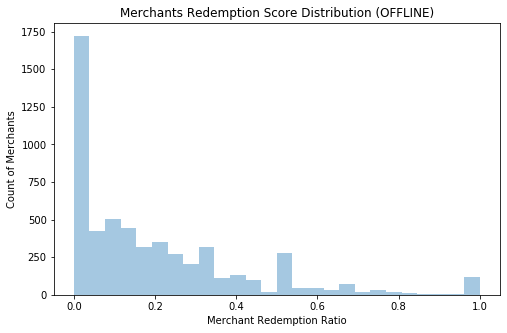

In [17]:
plt.figure(figsize=(8,5))
sns.distplot(merchant_redemption_offline['Merchant_Ratio'],kde=False,bins=26)
plt.xlabel('Merchant Redemption Ratio')
plt.ylabel('Count of Merchants')
plt.title('Merchants Redemption Score Distribution (OFFLINE)')
plt.show()

In [18]:
#Merchants in online Dataset
merchant_redemption_online = df_on_coupon.groupby(['Merchant_id'])['Coupon_id','Date'].count()
merchant_redemption_online.columns = ['Merchant_Released', 'Merchant_Redeemed']
merchant_redemption_online['Merchant_Ratio'] = round(merchant_redemption_online['Merchant_Redeemed']
                                                     /merchant_redemption_online['Merchant_Released'],2)
merchant_redemption_online.sample(5)

,Merchant_Released,Merchant_Redeemed,Merchant_Ratio
Merchant_id,,,
22712,208,28,0.13
59302,8,2,0.25
34911,68,2,0.03
47612,187,25,0.13
24309,270,13,0.05


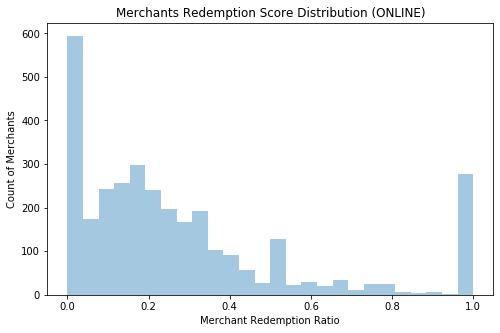

In [19]:
plt.figure(figsize=(8,5))
sns.distplot(merchant_redemption_online['Merchant_Ratio'],kde=False,bins=26)
plt.xlabel('Merchant Redemption Ratio')
plt.ylabel('Count of Merchants')
plt.title('Merchants Redemption Score Distribution (ONLINE)')

plt.show()

### Merchant and Average Distance of its customers (OFFLINE)

In [20]:
merchant_distance = pd.DataFrame(df_off_unique.groupby(['Merchant_id'])['Distance']
                                 .agg(['mean','count'])).reset_index()
merchant_distance.columns = ['Merchant_id','Merchant_AvgDistance','Count']
merchant_distance.head()

,Merchant_id,Merchant_AvgDistance,Count
0,1,0.000000,14
1,2,6.181818,11
2,3,5.000000,18
3,4,0.050000,40
4,5,1.531646,79


In [21]:
merchant_distance['Count'].describe()

count      8415.000000
mean        204.039335
std        2402.292293
min           1.000000
25%           8.000000
50%          19.000000
75%          50.000000
max      140811.000000
Name: Count, dtype: float64

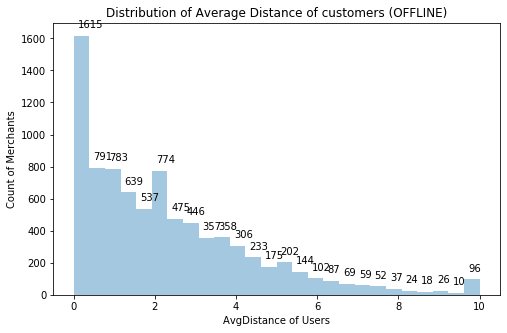

In [22]:
plt.figure(figsize=(8,5))
ax = sns.distplot(merchant_distance['Merchant_AvgDistance'],kde=False,bins=26)
plt.xlabel('AvgDistance of Users')
plt.ylabel('Count of Merchants')
plt.title('Distribution of Average Distance of customers (OFFLINE)')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.show()

### Merchant and its Popularity  (OFFLINE)
(based on number of visits of its customers)<br>
If visits > 40:
    then Merchant is Popular

In [23]:
df_off_purchase = df_off_unique[df_off_unique['Date'].isna()==False]
merchant_visits_off = pd.DataFrame(df_off_purchase.groupby(['Merchant_id','User_id','Date'])['Distance']
                                   .count()).reset_index()

merchant_visits_offline = pd.DataFrame(df_off_unique.groupby(['Merchant_id'])['Date'].count()).reset_index()

merchant_visits_offline = merchant_visits_offline.rename(columns={"Date": "Merchant_Visits"})
merchant_visits_offline.head()

,Merchant_id,Merchant_Visits
0,1,14
1,2,4
2,3,9
3,4,38
4,5,54


In [24]:
merchant_visits_offline['Merchant_Visits'].describe()

count     8415.000000
mean        92.057754
std        827.884372
min          0.000000
25%          6.000000
50%         14.000000
75%         37.000000
max      35885.000000
Name: Merchant_Visits, dtype: float64

In [25]:
merchant_visits_offline['Merchant_Popular'] = [1 if x>40 else 0 
                                               for x in merchant_visits_offline['Merchant_Visits']]
merchant_visits_offline.sample(5)

,Merchant_id,Merchant_Visits,Merchant_Popular
3286,3444,17,0
1634,1714,21,0
2924,3061,3,0
689,731,23,0
3539,3713,10,0


### Merchants and its Active duration

In [26]:
merchant_duration = df_off_unique.copy()
merchant_duration['DateTrack'] = merchant_duration['Date']
merchant_duration.DateTrack.fillna(merchant_duration.Date_received, inplace=True)
merchant_duration.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,DateTrack
0,4,1433,8735.0,30:5,10,2016-02-14,NaT,1,2016-02-14
1,4,1469,2902.0,0.95,10,2016-06-07,NaT,1,2016-06-07
2,35,3381,1807.0,300:30,0,2016-01-30,NaT,1,2016-01-30
3,35,3381,9776.0,10:5,0,2016-01-29,NaT,1,2016-01-29
4,35,3381,11951.0,200:20,0,2016-01-29,NaT,1,2016-01-29


In [27]:
merchant_duration_days = pd.DataFrame( merchant_duration.groupby(['Merchant_id'])['DateTrack']
                                     .agg(['min','max'])).reset_index()
merchant_duration_days.columns = ['Merchant_id','StartDate', 'EndDate']
merchant_duration_days['MerchantDuration'] = merchant_duration_days['EndDate']-merchant_duration_days['StartDate']
merchant_duration_days.head()

,Merchant_id,StartDate,EndDate,MerchantDuration
0,1,2016-01-15,2016-06-21,158 days
1,2,2016-05-15,2016-06-17,33 days
2,3,2016-04-24,2016-06-28,65 days
3,4,2016-02-18,2016-06-28,131 days
4,5,2016-01-01,2016-06-29,180 days


In [28]:
merchant_duration_days['MerchantDuration'] = merchant_duration_days['MerchantDuration'].dt.days.astype('str')
merchant_duration_days['MerchantDuration'] = pd.to_numeric(merchant_duration_days['MerchantDuration'],errors="coerce")
merchant_duration_days.head()

,Merchant_id,StartDate,EndDate,MerchantDuration
0,1,2016-01-15,2016-06-21,158
1,2,2016-05-15,2016-06-17,33
2,3,2016-04-24,2016-06-28,65
3,4,2016-02-18,2016-06-28,131
4,5,2016-01-01,2016-06-29,180


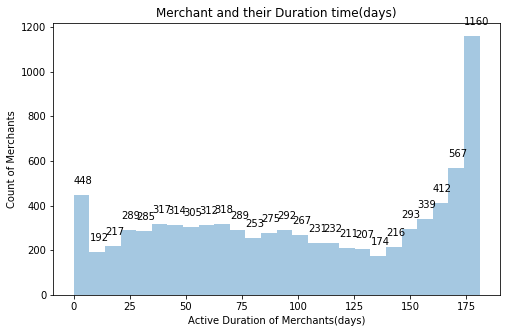

In [29]:
plt.figure(figsize=(8,5))
ax = sns.distplot(merchant_duration_days['MerchantDuration'],kde=False,bins=26)
plt.xlabel('Active Duration of Merchants(days)')
plt.ylabel('Count of Merchants')
plt.title('Merchant and their Duration time(days)')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

### Avg discount each merchant offers

In [30]:
#avg discounts each merchant offers
merchant_discounts_avg = pd.DataFrame(df_off_coupon.groupby(['Merchant_id'])['Rate'].mean())
merchant_discounts_avg.columns = ['Merchant_AvgRate']
merchant_discounts_avg = merchant_discounts_avg.reset_index()
merchant_discounts_avg.head()

,Merchant_id,Merchant_AvgRate
0,2,0.800
1,3,0.667
2,4,0.833
3,5,0.750
4,8,0.500


Text(0.5, 1.0, 'Merchant and Average Discount it offers')

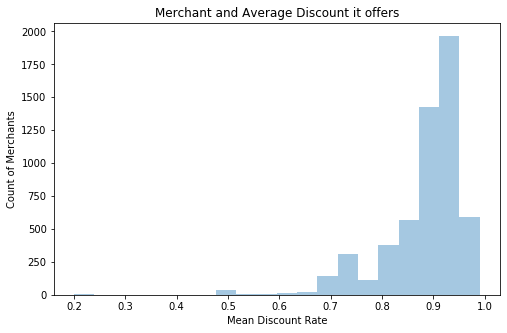

In [31]:
plt.figure(figsize=(8,5))
sns.distplot(merchant_discounts_avg['Merchant_AvgRate'],kde=False,bins=20)
plt.xlabel('Mean Discount Rate')
plt.ylabel('Count of Merchants')
plt.title('Merchant and Average Discount it offers')

### Number of different coupons released by different merchants

In [32]:
different_coupons = pd.DataFrame(df_off_coupon.groupby(['Merchant_id'])['Coupon_id'].nunique()).reset_index()
different_coupons.columns = ['Merchant_id','Different_Coupons']
different_coupons['Different_Coupons'].unique()

array([ 1,  2,  4,  5,  3,  6, 12, 22, 11,  8, 19,  9,  7, 39, 10, 14, 25,
       13, 21, 15])

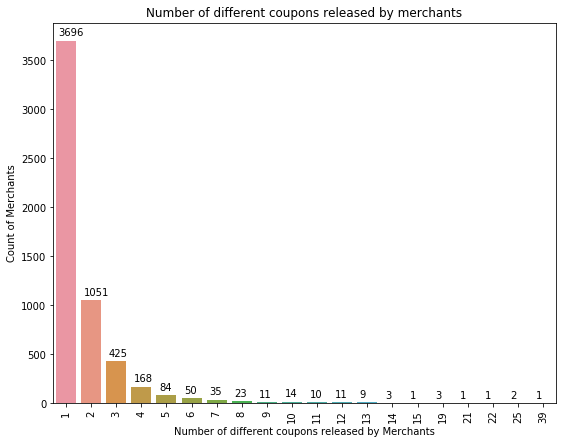

In [33]:
plt.figure(figsize=(9,7))
ax = sns.countplot(different_coupons['Different_Coupons'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
plt.xlabel('Number of different coupons released by Merchants')
plt.ylabel('Count of Merchants')
plt.title('Number of different coupons released by merchants')
plt.show()

## Merchant and its last visiting window

In [34]:
merchant_days = df_off_unique[df_off_unique['Date'].isna()==False]
merchant_days['First_day'] = pd.to_datetime('20160101',format='%Y%m%d')
merchant_days['DayNum'] = merchant_days['Date'] - merchant_days['First_day'] 
merchant_days['DayNum'] = merchant_days['DayNum'].dt.days.astype('str')
merchant_days['DayNum'] = pd.to_numeric(merchant_days['DayNum'],errors="coerce") + 1
merchant_days.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,First_day,DayNum
15,165,2934,NaN,NaN,0,NaT,2016-01-11,1,2016-01-01,11
16,165,2934,NaN,NaN,0,NaT,2016-01-25,1,2016-01-01,25
17,165,2934,NaN,NaN,0,NaT,2016-03-21,1,2016-01-01,81
18,165,2934,NaN,NaN,0,NaT,2016-03-28,1,2016-01-01,88
19,165,2934,NaN,NaN,0,NaT,2016-04-14,1,2016-01-01,105


In [35]:
merchant_days = pd.DataFrame(merchant_days.groupby(['Merchant_id'])['DayNum']
                             .apply(list).reset_index(name='VisitList'))

In [36]:
merchant_days['VisitList'] = merchant_days['VisitList'].apply(lambda x : sorted(set(x)))
merchant_days

,Merchant_id,VisitList
0,1,"[15, 58, 61, 136, 140, 143, 144, 146, 150, 152..."
1,2,"[142, 153, 163, 169]"
2,3,"[115, 118, 120, 123, 126, 127, 132, 180]"
3,4,"[49, 50, 57, 59, 60, 61, 63, 64, 71, 91, 95, 1..."
4,5,"[1, 4, 6, 8, 10, 14, 24, 28, 30, 67, 71, 75, 8..."
...,...,...
8316,8852,"[131, 134, 137, 140, 142, 145, 146, 152, 155, ..."
8317,8853,"[91, 94, 96, 98, 102, 105, 113, 117, 120, 121,..."
8318,8854,"[126, 137, 141, 146, 151, 153, 160, 166, 167, ..."
8319,8855,"[74, 76, 77, 83, 84, 85, 89, 96, 105, 116, 120..."


## Merchant and its last Redemption window

In [37]:
merchant_red_days = df_off_coupon[df_off_coupon['Date'].isna()==False]
merchant_red_days['First_day'] = pd.to_datetime('20160101',format='%Y%m%d')
merchant_red_days['DayNum'] = merchant_red_days['Date'] - merchant_red_days['First_day'] 
merchant_red_days['DayNum'] = merchant_red_days['DayNum'].dt.days.astype('str')
merchant_red_days['DayNum'] = pd.to_numeric(merchant_red_days['DayNum'],errors="coerce") + 1
merchant_red_days.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,Count,Discount,Original_price,Discounted_price,Rate,First_day,DayNum
33,184,3381,9776.0,"[10, 5, 0.5]",0,2016-01-29,2016-02-28,1,10:5,10,5,0.500,2016-01-01,59
76,417,775,5435.0,"[30, 5, 0.833]",0,2016-03-29,2016-04-12,1,30:5,30,5,0.833,2016-01-01,103
150,687,6454,14031.0,"[100, 10, 0.9]",2,2016-01-28,2016-01-30,1,100:10,100,10,0.900,2016-01-01,30
153,687,8594,9353.0,"[30, 1, 0.967]",2,2016-03-28,2016-04-02,1,30:1,30,1,0.967,2016-01-01,93
158,696,4195,3726.0,"[100, 10, 0.9]",0,2016-04-11,2016-04-13,1,0.9,100,10,0.900,2016-01-01,104


In [38]:
merchant_red_days = pd.DataFrame(merchant_red_days.groupby(['Merchant_id'])['DayNum'].apply(list).reset_index(name='MerchantRedemptionList'))

In [39]:
merchant_red_days['MerchantRedemptionList'] = merchant_red_days['MerchantRedemptionList'].apply(lambda x : sorted(set(x)))
merchant_red_days

,Merchant_id,MerchantRedemptionList
0,3,[180]
1,4,"[158, 160, 163, 166, 168]"
2,5,"[148, 153]"
3,13,[24]
4,14,[21]
...,...,...
4071,8844,"[99, 123, 127, 130, 143, 147, 149, 156, 162, 167]"
4072,8849,[160]
4073,8850,"[110, 141, 172]"
4074,8852,[146]


## Merchant and Average Daily New Users

In [40]:
merchant_dailyusers = pd.DataFrame(merchant_duration.groupby(['Merchant_id', 'Date'])['User_id'].nunique().reset_index(name='DailyUsers'))
merchant_avg_daily_users = pd.DataFrame(merchant_dailyusers.groupby(['Merchant_id'])['DailyUsers'].mean().reset_index(name='AvgDailyUsers'))
merchant_avg_daily_users.head()

,Merchant_id,AvgDailyUsers
0,1,1.076923
1,2,1.000000
2,3,1.125000
3,4,1.000000
4,5,1.227273


## Merchant and count of unique users 

In [41]:
merchant_unique_users = pd.DataFrame(df_off_unique.groupby(['Merchant_id'])['User_id']
                                     .nunique().reset_index(name='UniqueUsersCount'))

## Merchant and number of buys

In [43]:
merchant_buys = pd.DataFrame(df_off_unique.groupby(['Merchant_id'])['Date']
                             .count().reset_index(name='Merchant_Buys'))
merchant_buys

,Merchant_id,Merchant_Buys
0,1,14
1,2,4
2,3,9
3,4,38
4,5,54
...,...,...
8410,8852,14
8411,8853,40
8412,8854,12
8413,8855,14


## Merchant Level Features

In [53]:
merchants_level_data = pd.DataFrame(df_off_unique['Merchant_id'].unique()).reset_index(drop=True)
merchants_level_data.columns = ['Merchant_id']
merchants_level_data.shape

(8415, 1)

In [54]:
#Adding Number of coupons redeemed and its redemption score for each merchant
merchants_level_data = pd.merge(merchants_level_data, merchant_redemption_offline['Merchant_Redeemed'], how='left', left_on='Merchant_id', right_on=merchant_redemption_offline['Merchant_id'])
merchants_level_data = pd.merge(merchants_level_data, merchant_redemption_offline['Merchant_Ratio'], how='left', left_on='Merchant_id', right_on=merchant_redemption_offline['Merchant_id'])

#Adding merchants and average distance of its users
merchants_level_data = pd.merge(merchants_level_data, merchant_distance['Merchant_AvgDistance'], how='left', left_on='Merchant_id', right_on=merchant_distance['Merchant_id'])

#Merchant is Popular(Visits>40) or Not Popular
merchants_level_data = pd.merge(merchants_level_data, merchant_visits_offline['Merchant_Popular'], how='left', left_on='Merchant_id', right_on=merchant_visits_offline['Merchant_id'])

#Adding merchants and average discount it offers
merchants_level_data = pd.merge(merchants_level_data, merchant_discounts_avg['Merchant_AvgRate'], how='left', left_on='Merchant_id', right_on=merchant_discounts_avg['Merchant_id'])

#Adding merchants and its duration
# merchants_level_data = pd.merge(merchants_level_data, merchant_duration_days['MerchantDuration'], how='left', left_on='Merchant_id', right_on=merchant_duration_days['Merchant_id'])

#Daily new users (average) for a merchant
merchants_level_data = pd.merge(merchants_level_data, merchant_avg_daily_users, how='left', on='Merchant_id')

#Last Visiting window for the merchant
merchants_level_data = pd.merge(merchants_level_data,merchant_days,how='left',on='Merchant_id')
for row in merchants_level_data.loc[merchants_level_data.VisitList.isnull(), 'VisitList'].index:
    merchants_level_data.at[row, 'VisitList'] = []
    
# Merchant and count of unique users
merchants_level_data = pd.merge(merchants_level_data, merchant_unique_users, how='left', on='Merchant_id')
    
# Merchant and count of unique users
merchants_level_data = pd.merge(merchants_level_data, merchant_buys, how='left', on='Merchant_id')

#Last Redemption window for the merchant
merchants_level_data = pd.merge(merchants_level_data,merchant_red_days,how='left',on='Merchant_id')
for row in merchants_level_data.loc[merchants_level_data.MerchantRedemptionList.isnull(), 'MerchantRedemptionList'].index:
    merchants_level_data.at[row, 'MerchantRedemptionList'] = []


In [55]:
merchants_level_data.fillna(0, inplace=True)

In [56]:
merchants_level_data.shape

(8415, 11)

In [57]:
merchants_level_data['Merchant_Redeemed_Buy'] = [x/y if y!=0 else 0 for x,y in 
                                        zip(merchants_level_data['Merchant_Redeemed'],
                                            merchants_level_data['Merchant_Buys'])]

In [58]:
merchants_level_data.head()

,Merchant_id,Merchant_Redeemed,Merchant_Ratio,Merchant_AvgDistance,Merchant_Popular,Merchant_AvgRate,AvgDailyUsers,VisitList,UniqueUsersCount,Merchant_Buys,MerchantRedemptionList,Merchant_Redeemed_Buy
0,1433,726.0,0.04,3.927992,1,0.810455,49.697802,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",19340,9045,"[24, 25, 27, 29, 30, 31, 33, 34, 35, 36, 37, 3...",0.080265
1,1469,675.0,0.05,2.617818,1,0.707819,74.527473,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",13702,13576,"[9, 10, 14, 15, 20, 21, 30, 31, 61, 64, 65, 66...",0.049720
2,3381,2473.0,0.02,2.690394,1,0.866463,119.587912,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",108018,21829,"[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...",0.113290
3,1041,402.0,0.05,2.846591,1,0.831778,19.510989,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",7966,3553,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",0.113144
4,5717,293.0,0.02,2.255078,1,0.751612,21.571429,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",12506,3927,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...",0.074612


In [59]:
merchants_level_data.to_csv('DataSets/DatasetsCreated/merchant_level.csv',index=False)